#  Logistic Regression and Classification Error Metrics

## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

For each record in the dataset it is provided: 

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration. 
- Triaxial Angular velocity from the gyroscope. 
- A 561-feature vector with time and frequency domain variables. 
- Its activity label. 

More information about the features is available on the website: above or at https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones 

In [30]:
from __future__ import print_function
import os
#Data Path has to be set as per the file location in your system
#data_path = ['..', 'data']
data_path = ['/Users/Samuel/Desktop/Development/Git_Hub/TP_Regressao_Logistica-pt2/CI_Logistic_Regression-pt2']

## Question 1

Import the data and do the following:

* Examine the data types--there are many columns, so it might be wise to use value counts
* Determine if the floating point values need to be scaled
* Determine the breakdown of each activity
* Encode the activity label as an integer

In [67]:
import pandas as pd
import numpy as np
#The filepath is dependent on the data_path set in the previous cell 
filepath = os.sep.join(data_path + ['Human_Activity_Recognition_Using_Smartphones_Data.csv'])
data = pd.read_csv(filepath, sep=',')

The data columns are all floats except for the activity label.

In [68]:
data.dtypes.value_counts()

float64    561
object       1
dtype: int64

In [69]:
data.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

The data are all scaled from -1 (minimum) to 1.0 (maximum).

In [70]:
data.iloc[:, :-1].min().value_counts()

-1.0    561
dtype: int64

In [71]:
data.iloc[:, :-1].max().value_counts()

1.0    561
dtype: int64

Examine the breakdown of activities--they are relatively balanced.

In [72]:
data.Activity.value_counts()

LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: Activity, dtype: int64

Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.  
Use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.

In [73]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(5)

7158    5
2772    0
3342    0
3500    0
378     1
Name: Activity, dtype: int64

## Question 2

* Calculate the correlations between the dependent variables.
* Create a histogram of the correlation values
* Identify those that are most correlated (either positively or negatively).

In [74]:
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values.stack().to_frame().reset_index().rename(columns={'level_0':'feature1','level_1':'feature2',0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

A histogram of the absolute value correlations.

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

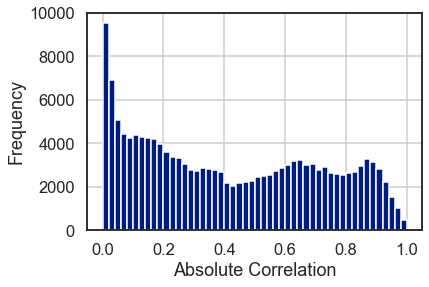

In [76]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

ax = corr_values.abs_correlation.hist(bins=50)

ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [77]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
93902,tBodyAccMag-sma(),tGravityAccMag-sma(),1.000000,1.000000
101139,tBodyAccJerkMag-mean(),tBodyAccJerkMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
94257,tBodyAccMag-energy(),tGravityAccMag-energy(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


## Question 3

* Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
* Regardless of methods used to split the data, compare the ratio of classes in both the train and test splits.


In [78]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1,test_size=0.3, random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']

In [79]:
y_train.value_counts(normalize=True)

0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: Activity, dtype: float64

In [80]:
y_test.value_counts(normalize=True)

0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: Activity, dtype: float64

## Question 4

* Fit a logistic regression model without any regularization using all of the features. Be sure to read the documentation about fitting a multi-class model so you understand the coefficient output. Store the model.
* Using cross validation to determine the hyperparameters, fit models using L1, and L2 regularization. Store each of these models as well. Note the limitations on multi-class models, solvers, and regularizations. The regularized models, in particular the L1 model, will probably take a while to fit.

In [55]:
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
lr = LogisticRegression(max_iter=500, penalty='none').fit(X_train, y_train)
lr.coef_

array([[-1.12753241e+02,  2.17473305e+01,  2.45980653e+01, ...,
         9.53565032e+02, -3.76644087e+02, -6.82954926e+01],
       [-3.63002811e+02, -1.45168850e+02,  4.20596431e+01, ...,
        -9.63621538e+01, -1.91236271e+02, -1.29107255e+02],
       [ 1.68917715e+02,  1.10952883e+02,  1.22638853e+02, ...,
        -4.20272436e+02,  3.28980342e+02,  1.70286659e+01],
       [-8.56589782e+00, -2.41487603e+01,  3.06382555e+00, ...,
        -1.76212251e+02,  1.14312819e+01,  8.12989496e+01],
       [ 2.30427066e+02,  5.25608146e+01,  3.51594570e-01, ...,
        -3.66623233e+02, -3.00660366e+01, -1.88568620e+01],
       [ 8.49771695e+01, -1.59434179e+01, -1.92711982e+02, ...,
         1.05905042e+02,  2.57534771e+02,  1.17931994e+02]])

In [56]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

In [ ]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations

In [57]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', max_iter=10000).fit(X_train, y_train)

### Breve explicação:

Foram expostos os coeficientes de cada regressão logistica com o seus respectivos algoritmos de solução. Houve uma demora considerável com o uso do algoritmo 'liblinear', isso se dá pelo fato que o algoritmo 'liblinear' usar o método de resolução 'um por todos' (onde cada conjunto de dados de uma classe é comparada com o conjunto de dados das outras restantes) esse, é mais viável para um conjunto de dados menor. Esses algoritmos de otimização possuem a vantagem de não precisarem do alfa, como no calculo do gradiente, entretanto com a desvantagem de serem mais complexos. Acima foi utilizado dois algoritmos com as suas respectivas penalidades necessárias e uma plotagem para analisarmos a eficiente desses. Nota-se que existe uma diferença na eficiencia do algoritmo liblinear em relação ao de newton.

## Question 5

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [58]:
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    levels=[[lab], [0,1,2,3,4,5]]
    labels=[[0,0,0,0,0,0], [0,1,2,3,4,5]]
    coeff_label = pd.MultiIndex(levels,labels)
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

#for lab,mod in zip(coeff_labels, coeff_models):
#    coeffs = mod.coef_
#    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
#                                 labels=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
#    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)

lr                                                              \
              0           1           2           3           4           5   
363 -142.904681 -201.567202  -24.640630   92.584574  309.671418  -33.143480   
143 -174.615326    5.452319  -15.334364 -196.802487  252.295622  129.004234   
43   203.944036   17.148860  237.532947 -117.594374 -194.505833 -146.525635   
466    2.759316   42.166129   66.497627    9.752029 -117.385878   -3.789223   
411  -12.526076   34.799830   51.894504  -75.679549  154.377009 -152.865719   
156  -29.487290 -833.491362  656.684157  420.176692    6.162232 -220.044431   
446 -200.243800  153.723956 -536.571827  216.254644  208.917648  157.919380   
396  -40.142600   -2.447743   25.112998  163.121114  -51.720883  -93.922887   
326  -26.714261   24.121555    5.298959  -29.784738  106.216417  -79.137933   
196  -30.840325 -281.627542  437.538877  -61.614002 -306.570796  243.113788   

           l1                                                          l2  \
            0         1         2         3         4         5         0   
363  0.000000  0.000000  0.000000  0.377849  0.000000 -1.753274 -0.074101   
143  0.000000 -0.716483  0.123833 -2.430722  3.630737 -0.384798 -0.192226   
43   0.100779  0.000037  1.056583  0.188470 -0.154240  0.133592  0.145979   
466 -0.001091  0.292345  0.336214  0.246992  0.000000  0.397332 -0.015661   
411 -0.167217  0.000000  0.000000 -0.099859  0.223774 -0.037516 -0.017639   
156  0.000000 -3.461902  2.225147  1.112315 -1.222938 -6.981186  0.069585   
446  0.000000  1.176885 -1.645523  0.164302 -0.206232  0.114741 -0.079624   
396 -0.017868  0.000000  0.000000  0.311111  0.000000 -0.393143 -0.026882   
326  0.000000  0.000000  0.000000  0.007856  0.184339  0.070072 -0.014835   
196  0.000000 -1.328116  1.481099  0.000000 -0.580419 -0.834396 -0.089484   

                                                       
            1         2         3         4         5  
363 -0.289227  0.063017  0.110989  0.405820 -0.216497  
143 -0.018882  0.260453 -0.667851  0.510233  0.108274  
43  -0.044792  0.227630 -0.097022 -0.135443 -0.096352  
466 -0.011204 -0.006852  0.003945 -0.091878  0.121650  
411  0.005140 -0.020516 -0.073387  0.333385 -0.226983  
156 -1.204086  1.080670  0.700352  0.015921 -0.662443  
446  1.038724 -1.239731  0.259167  0.037253 -0.015788  
396 -0.031324 -0.031133  0.302546 -0.004952 -0.208255  
326  0.019083 -0.058499  0.064382  0.118495 -0.128627  
196 -0.645029  0.756579  0.075990 -0.218504  0.120448

### Breve explicação:

Como sabemos, quando utilizamos a regressão logística para rótulos multiclasse, o modelo encontrará um conjunto de coeficientes para cada classe, devido ao "método um vs resto". Assim, cada modelo contém 6 conjuntos de coeficientes que diferem uns dos outros.

Prepare six separate plots for each of the multi-class coefficients.

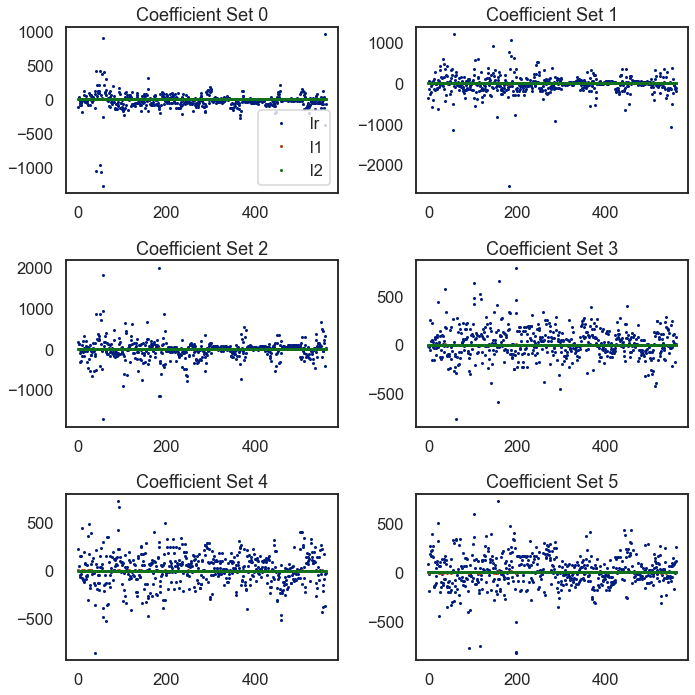

In [59]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data = coefficients.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()


### Breve explicação:

Nas imagens acime, foi representado graficamente os conjuntos de coeficientes obtidos para a primeira classe com a rotulação por cor nos 3 modelos, em seguida, aplicou-se o mesmo para a segunda classe e sucessivamente.

## Question 6

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [60]:
# Predict the class and the probability for each

y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()


,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


In [61]:
y_prob.head()

,lr,l1,l2
0,1.0,0.998871,0.999998
1,1.0,0.999502,0.999656
2,1.0,0.995339,0.998874
3,1.0,0.999169,0.997831
4,1.0,0.999921,0.999304


### Breve explicação:

Acima, está sendo exibido duas tabelas que mostram a regressão e a probabilidade para cada curva.

## Question 7

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [62]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)


In [63]:
#Run the metrics
metrics

,lr,l1,l2
precision,0.980888,0.983835,0.983485
recall,0.980906,0.983819,0.983495
fscore,0.980884,0.983815,0.983488
accuracy,0.980906,0.983819,0.983495
auc,0.988437,0.990144,0.989983


### Breve Explicação:

Na tabela acima, não vemos uma diferença estatisticamente significativa nas métricas de erro entre os 3 modelos, mesmo usando apenas o primeiro (sem regularização) podemos esperar um ótimo desempenho na previsão das atividades.

## Question 8

Display or plot the confusion matrix for each model.

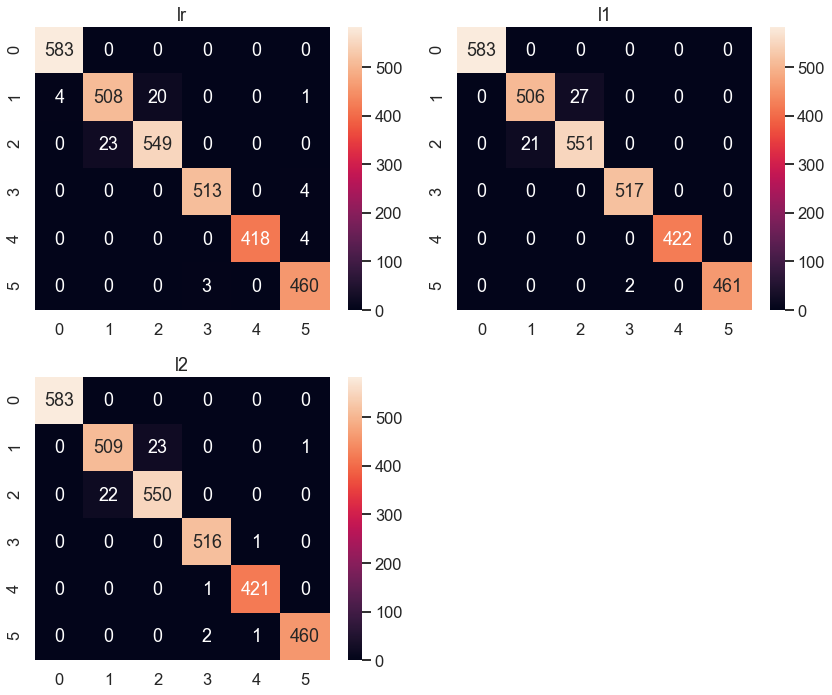

In [64]:

fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()


### Breve explicação:

Para ver uma diferença um pouco mais destacada, foi traçado a matriz de confusão correspondente aos modelos. Podemos inferir com a matriz de confusão 3 que todo modelo tem um pequeno problema em prever as classes 1 e 2 talvez.

## Question 9
 Identify highly correlated columns and drop those columns before building models

In [81]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

X_data = data.iloc[:, :-1]
 
#threshold with .7
sel = VarianceThreshold(threshold=(.7 * (1 - .7)))
X_data = pd.DataFrame(sel.fit_transform(X_data))
 
feature_cols = X_data.columns[:]
 
# Dividindo os subjconjuntos de treino e teste, seguindo os mesmos
# Indices obtidos com Stratified Shuffle Split, agora com os dados
# Com menos features

# ISSO NÃO FUNCIONA e NÃO FAZ SENTIDO X_data.loc[test_idx, :] e #X_train_new = X_data.loc[train_idx, :].

#X_train_new = X_data.loc[train_idx, :]
X_train_new = X_data.reindex(columns = train_idx)
y_train_new = data.loc[train_idx, 'Activity']

#X_test_new  = X_data.loc[test_idx, :]
X_test_new  = X_data.reindex(columns = test_idx)
y_test_new  = data.loc[test_idx, 'Activity']

print(X_train.shape)
print(X_train_new.shape)
print(X_test.shape)
print(X_test_new.shape)


(7209, 561)
(10299, 7209)
(3090, 561)
(10299, 3090)


### Breve explicação:

Acima foi realizada, para a diminuição dos pequenos erros, a divisão dos subjconjuntos de treino e teste, seguindo os mesmos indices obtidos com Stratified Shuffle Split, agora com os dados com menos features.

 Repeat Model building with new training data after removing higly correlated columns

In [85]:
# Try standard, L1 and L2 Logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

# Standard logistic regression
lr = LogisticRegression(max_iter=500, penalty='none').fit(X_train_new, y_train_new)

# L1 regularized logistic regression
lr_l1_new = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train_new, y_train_new)

# L2 regularized logistic regression
# L2 regularized logistic regression
lr_l2_new = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', max_iter=10000).fit(X_train_new, y_train_new)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations

## Question 10

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [87]:
# Combine all the coefficients into a dataframe for comparison
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr_new, lr_l1_new, lr_l2_new]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)

lr                                                          l1  \
            0         1         2         3         4         5         0   
9   -0.089595 -1.044993 -0.142951 -0.991879  1.142181  1.023176  0.000000   
219  0.024451 -0.113410 -0.022481 -0.621021 -0.027568 -0.490645  0.000000   
135  0.006618  0.123801 -0.820911 -0.295131  0.040322  0.431400  0.000000   
301  0.227646 -0.207437  0.494148 -0.050528  0.258659 -0.065982  0.053079   
317 -0.024262  0.070896 -0.009851  0.464242  0.142857 -0.669523  0.000000   
532  0.040457  0.831840 -0.514372 -0.213901  0.512250 -0.044362  0.000000   
451 -0.118887  2.071692 -2.240813  0.160763 -0.834991 -0.062779  0.000000   
418 -0.003388  0.210512  0.201094 -0.105045  0.158601  0.011172  0.000000   
47   0.037983  0.208110  0.757572  0.221963  0.072469  0.000802  0.000000   
210 -0.011338  0.065728 -0.023260 -0.003970  0.293083  0.036449  0.000000   

                                                             l2            \
            1         2         3         4         5         0         1   
9   -3.830561  0.000000 -0.870796  2.838319  2.512672 -0.133154 -2.916885   
219  0.000000  0.000000 -0.348183 -0.076843 -0.493179  0.042324 -0.085363   
135  0.000000 -2.441556  0.000000  0.328003  0.338506  0.044492  1.738371   
301  0.000000  0.873592  0.000000  0.328439  0.000000  0.517446  0.911677   
317  0.000000  0.000000  0.598402  0.109427 -0.524404 -0.059729 -0.059766   
532  2.091620 -0.262281  0.000000  0.473172  0.220764  0.064596  2.697173   
451  1.315420 -1.904978  0.000000 -3.246308  0.000000 -0.179153  1.409516   
418  0.000000  0.025316  0.000000  0.194905  0.000000 -0.027419  0.648484   
47   0.420086  1.615515  0.069581  0.281461  0.001910  0.069330 -0.091974   
210  0.000000  0.000000  0.000000  1.320245  0.000000 -0.039560  0.646661   

                                             
            2         3         4         5  
9    0.445033 -2.120991  1.741936  2.507049  
219 -0.066619 -1.437574 -0.193975 -1.004569  
135 -3.077367 -0.623187  0.177071  0.811724  
301  0.332666 -0.140736  0.636718 -0.378920  
317 -0.046600  1.113840  0.415976 -1.366290  
532 -2.446163 -0.611734  1.316314  0.051685  
451 -2.005434  0.267916 -1.776274 -0.033500  
418  0.507165 -0.305813  0.255070 -0.016857  
47   1.946086  0.765647  0.217677 -0.233988  
210 -0.362955  0.167981  0.435624 -0.005912

Prepare six separate plots for each of the multi-class coefficients.

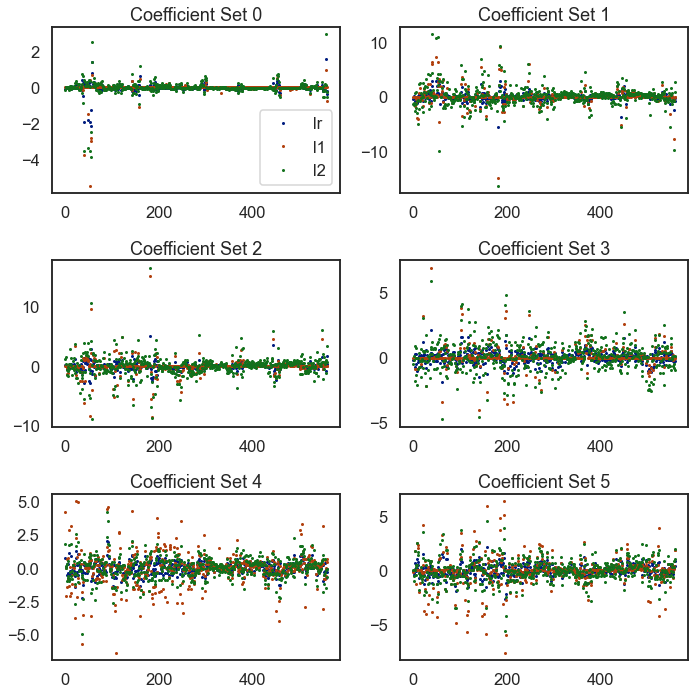

In [88]:
# try the plots

fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)

for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data = coefficients.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()

## Question 11

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [89]:
# Predict the class and the probability for each
y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr_new, lr_l1_new, lr_l2_new]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()


,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


## Question 12

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [90]:
# Calculate the error metrics as listed above
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)

In [91]:
#Run the metrics
metrics

,lr,l1,l2
precision,0.984144,0.983514,0.984477
recall,0.984142,0.983495,0.984466
fscore,0.984143,0.983492,0.984464
accuracy,0.984142,0.983495,0.984466
auc,0.990384,0.989949,0.990553


## Question 13

Display or plot the confusion matrix for each model.

In [ ]:
#plot the confusion matrix
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d', cmap=colors);
    ax.set(title=lab);
    
plt.tight_layout()

In [ ]:
# Perform a comparison of the outputs between Question 7 and 12 and give your observation

In [ ]:
# Perform a comparison of the outputs between Question 8 and 13 and give your observation